# find answer to the question: is the vaccine safe

In [1]:
pip install nltk

     |████████████████████████████████| 1.5 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 733 kB 19.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

     |████████████████████████████████| 371 kB 11.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install textblob

     |████████████████████████████████| 636 kB 6.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd # work with dataframe
import numpy as np # np matrix is used at cosine similarity

#from nltk.stem import WordNetLemmatizer # I was condidering doing lemmatization, but it didnt produce better result

from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer becasue papers may have common words that can
# mess up wtih similarity of papers. Tfidf considers weights of uniqueness of words, should be used here.

# cosine similarity:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# k means:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# topic modeling lda
from sklearn.decomposition import LatentDirichletAllocation

import re
import nltk

%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
from functools import reduce
import operator

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
data = pd.read_csv('reddit_vaccine_myths.csv')

In [9]:
data.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [10]:
data['score'].describe()

count    1491.000000
mean        3.800805
std        31.048088
min       -13.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      1189.000000
Name: score, dtype: float64

In [11]:
data_body=data['body']

In [12]:
data_body.head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: body, dtype: object

In [13]:
len(data_body)

1491

In [14]:
data_body=data_body.dropna()
len(data_body)

1125

In [15]:
data_body=data_body[data_body != 'You got it bud']
len(data_body)

1110

In [16]:
# Remove hyperlink address
data_body = data_body.apply(lambda x:re.sub(r"http\S+", "", x))

In [17]:
len(data_body)

1110

In [18]:
docs = data_body.tolist()
len(docs)

1110

In [19]:
docs[:20] # will regular expression remove web addresses later

["Your OP. It's not a myth. Only one vaccine contains it and you can get it without it. So your OP is pointless flex. ",
 '',
 'Because Anti-Vaxxers have no sense',
 'What do you mean by "your OP". I am fairly new to reddit.',
 "When they say there's no thimerasol, they mean in the childhood schedule. That IS a fact. ",
 'The "myth" you\'re debunking is in regards to the childhood schedule. ZERO OF THOSE VACCINES CONTAIN IT.  You\'re being a pedantic fuck for no reason. ',
 'You\'ll have to read it again because I didn\'t say that, the CDC did. You say one flu vaccine but the CDC says multiple. Check the CDC link. To paraphrase, "It\'s out of most single dose and in most multi-dose." That\'s more than one. I can\'t keep responding to people who won\'t even read what they\'re disagreeing with...',
 'Nope. I didn\'t say anything about childhood vaccines in my OP. The myth, as I stated plainly, is "Vaccines do not contain mercury." They do contain mercury. Not all, but some, so the statem

In [20]:
from nltk.corpus import stopwords
stop_words_ex = stopwords.words('english')
stop_words_ex.extend(['comment','vaccine','vaccines','virus','study','case','forum','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'people'])

In [21]:
vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=3, stop_words=stop_words_ex, ngram_range=(1,2))

In [22]:
# fit vocabulary in documents and transform the documents into vectors
vecs = vectorizer.fit_transform(docs)
vecs.shape

(1110, 2625)

In [23]:
vecs[:2]

<2x2625 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

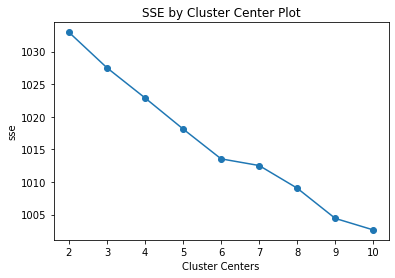

In [24]:
# determine k
# using elbowplot function from professor's sample code:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        kmeans_model = KMeans(n_clusters=k,random_state=0, n_init=20).fit(data)
        sse.append(kmeans_model.inertia_)
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('sse')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(vecs,10)

In [25]:
# clustering
# k=6 is a flattened point for SSE decease, thus I choose k=6
k = 6
km = KMeans(n_clusters=k, algorithm='auto', init='random', n_init=40, random_state=0, verbose=False)
km.fit(vecs)

lab=km.labels_

print(len(lab))

# label professors with clusters
pdf=pd.DataFrame({'cluster':lab,'text':data_body})

pdf[:15]

1110


,cluster,text
6,1,Your OP. It's not a myth. Only one vaccine con...
7,4,
8,3,Because Anti-Vaxxers have no sense
9,4,"What do you mean by ""your OP"". I am fairly new..."
10,4,"When they say there's no thimerasol, they mean..."
11,4,"The ""myth"" you're debunking is in regards to t..."
12,1,You'll have to read it again because I didn't ...
13,0,Nope. I didn't say anything about childhood va...
14,0,I didn't say thimerosal is mercury. I said thi...
15,4,Doctors recommend vaccines for whatever you're...


In [26]:
# pick the adjectives from text
# pdf=pd.DataFrame({'cluster':lab,'text':data_body})
pdf2 = pdf.set_index(['cluster'])

def get_adjectives(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag == "JJ"]

pdf2['text'] = pdf2['text'].str.lower()
pdf2['adjectives'] = pdf2['text'].apply(get_adjectives)

pdf2.sample(5)

,text,adjectives
cluster,,
4,yes and so do apples you dumb people.,[do]
1,why are you giving examples from other countri...,"[other, same, many, new, same, old, manufactur..."
4,that there is only an 11% gender imbalance yet...,[]
4,whey would someone think it is ok to give peop...,[ok]
4,why do you spread fear over something that has...,[]


In [27]:
pdf2

,text,adjectives
cluster,,
1,your op. it's not a myth. only one vaccine con...,[pointless]
4,,[]
3,because anti-vaxxers have no sense,[]
4,"what do you mean by ""your op"". i am fairly new...",[new]
4,"when they say there's no thimerasol, they mean...",[]
...,...,...
4,the problem is the calculations themselves and...,"[layperson, napkin, trusted, new]"
3,i created the vaxfact site using references to...,"[reliable, i]"
1,>the information i provided is not wrong\n\nyo...,"[wrong, nonsensical, incorrect, ludicrous, inn..."


In [28]:
cluster1 = pdf2.loc[0]
cluster2 = pdf2.loc[1]
cluster3 = pdf2.loc[2]
cluster4 = pdf2.loc[3]
cluster5 = pdf2.loc[4]
cluster6 = pdf2.loc[5]

In [29]:
cluster2

,text,adjectives
cluster,,
1,your op. it's not a myth. only one vaccine con...,[pointless]
1,you'll have to read it again because i didn't ...,"[single, multi-dose]"
1,herd immunity to me is a delegation of one's r...,[unbelievable]
1,"yes, that can be a few vaccinations. i've been...","[few, i]"
1,you make a good point about natural infection ...,"[good, natural, serious]"
...,...,...
1,so... the second one... is the one i said to p...,"[second, able]"
1,why are you giving examples from other countri...,"[other, same, many, new, same, old, manufactur..."
1,you misinterpreted some of what i said. i'm g...,"[important, virus-containing, indistinguishabl..."


In [30]:
nltk_stopwords = nltk.corpus.stopwords.words('english')

In [31]:
def alpha_filter(w):
    # pattern to match a word of non-alphabetical characters
    pattern = re.compile('^[^a-z]+$')
    if (pattern.match(w)):
        return True
    else:
        return False

In [32]:
def wordcloudgraph(dataframe):
    series = dataframe['adjectives'].values.tolist()
    stopped_tokens = [tok for tok in series if not tok in nltk_stopwords]
    stopped_tokens = reduce(operator.concat, stopped_tokens)
    token_filtered = [tok for tok in stopped_tokens if not alpha_filter(tok)]
    token_list = ' '.join([str(elem) for elem in stopped_tokens])
    
    wordcloud = WordCloud(background_color='white',width=3500, height=1600, margin=0, collocations=False).generate(token_list)

    # Display the generated image:
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='gaussian')
    plt.axis("off")
    plt.margins(x=1, y=1)
    plt.show()

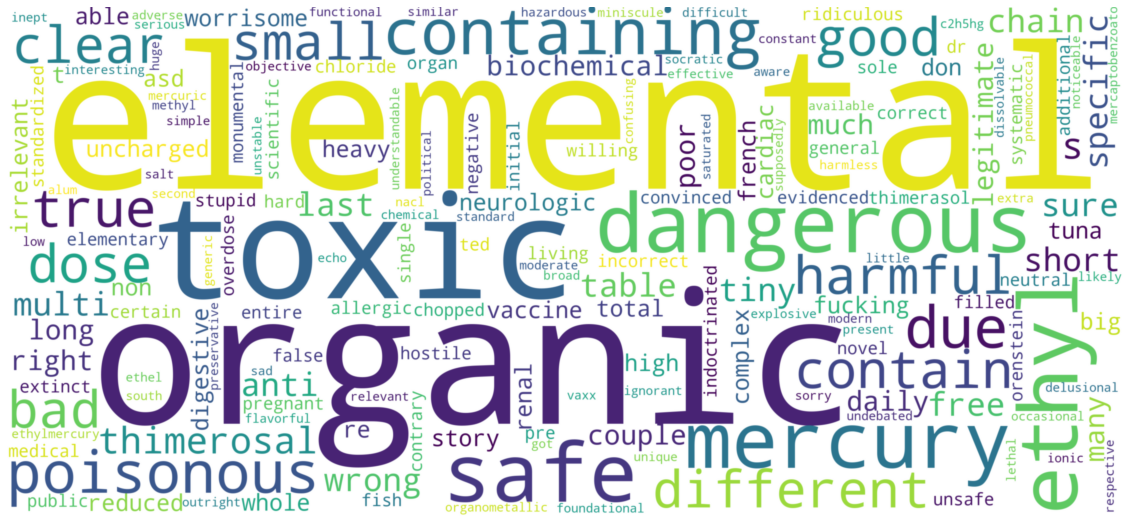

In [33]:
wordcloudgraph(cluster1)

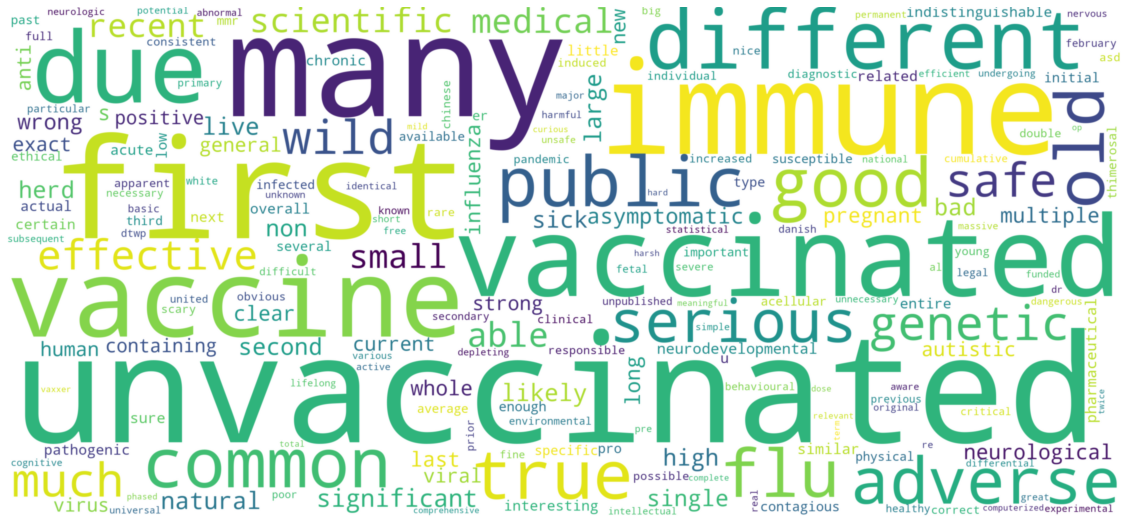

In [34]:
wordcloudgraph(cluster2)

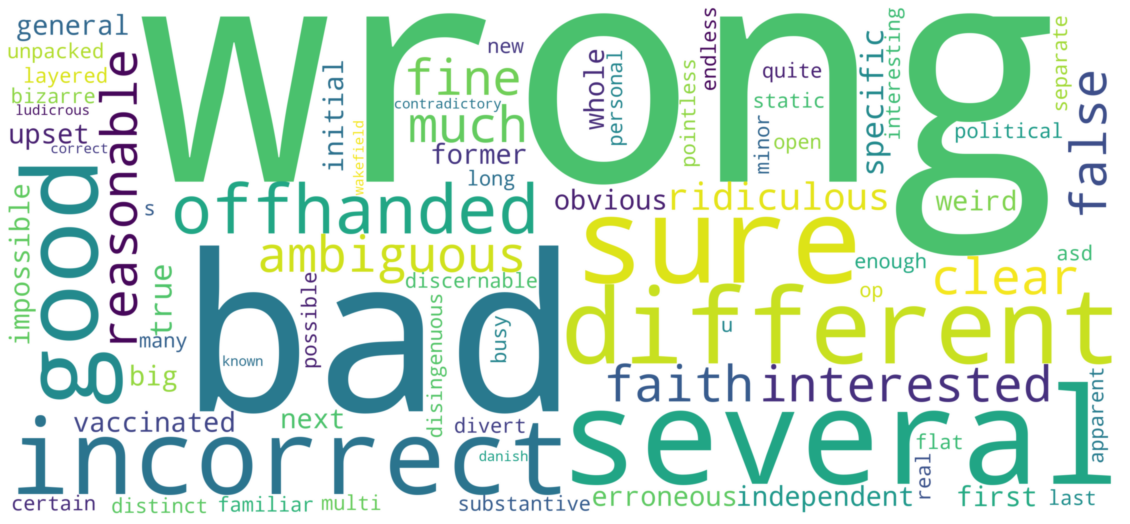

In [35]:
wordcloudgraph(cluster3)

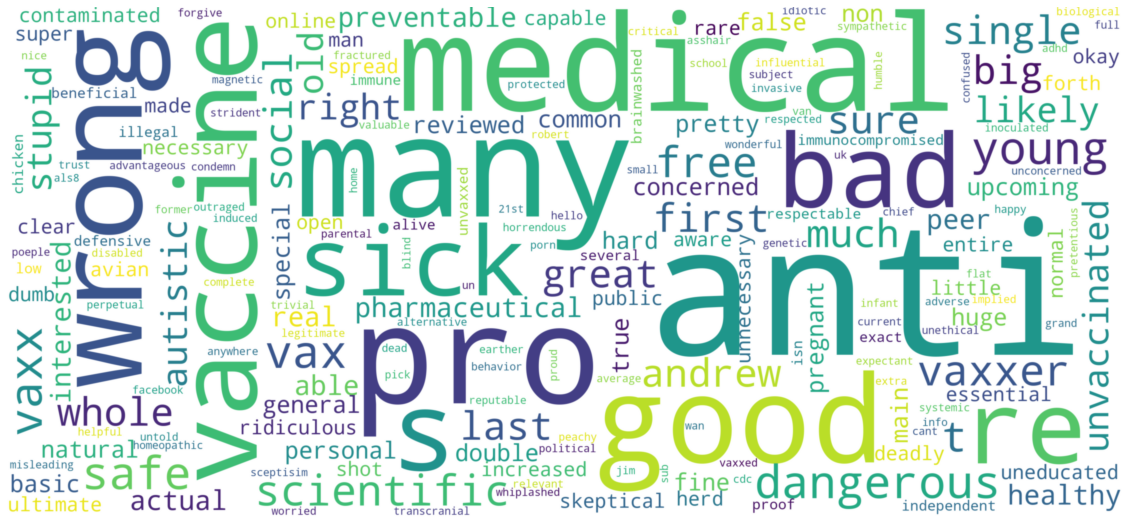

In [36]:
wordcloudgraph(cluster4)

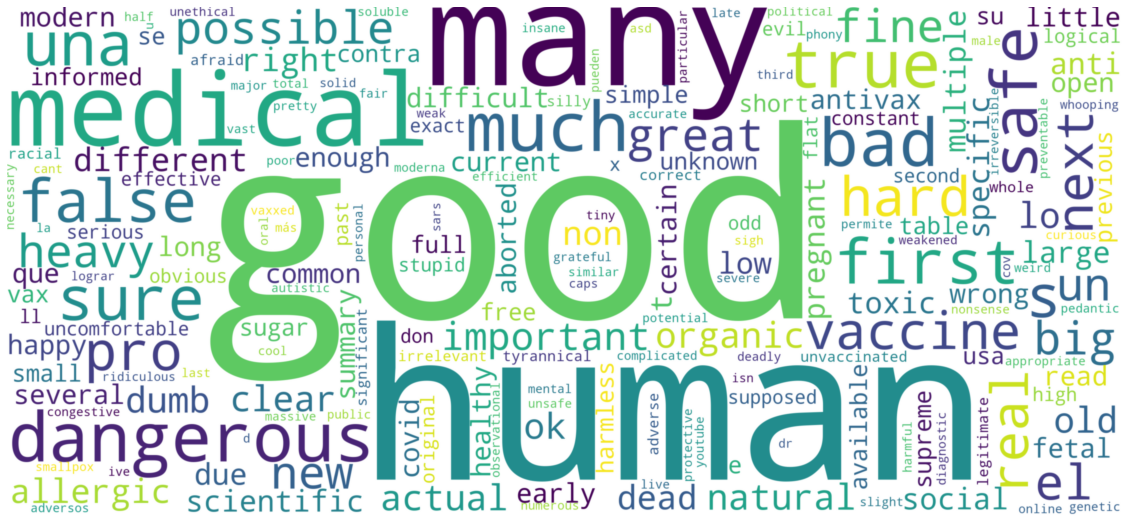

In [37]:
wordcloudgraph(cluster5)

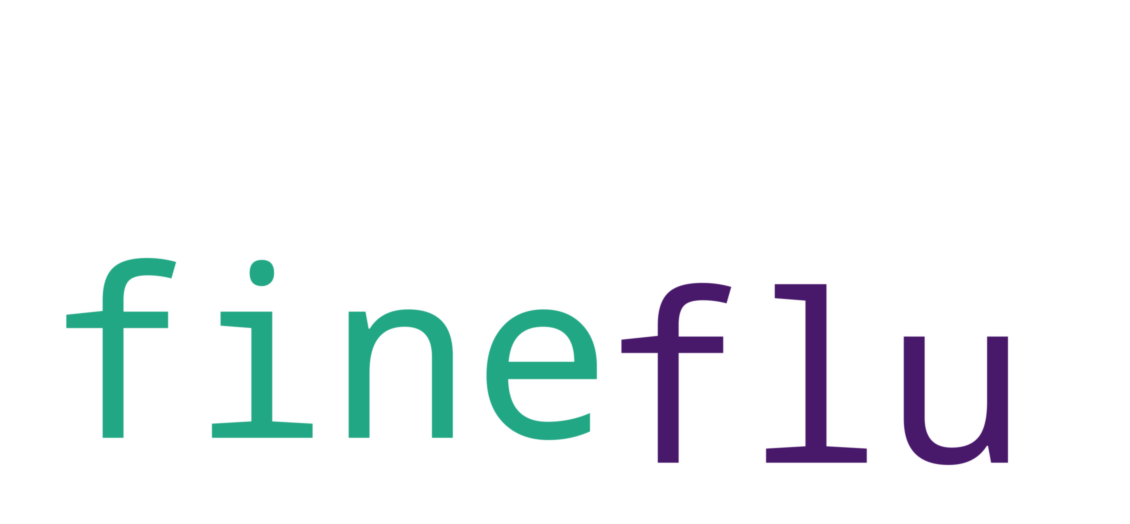

In [38]:
wordcloudgraph(cluster6)

In [39]:
# find best number of topics using ida.score()
# score() calculates approximate log-likelihood
topic_test=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for x in topic_test:
    lda = LatentDirichletAllocation(n_components=x, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
    lda_z = lda.fit_transform(vecs)
    print(x)
    print(lda.score(vecs))

1
-29159.9827557417
2
-30878.29916953075
3
-31916.946637949248
4
-32885.635065538416
5
-33765.09453997611
6
-34736.58807053424
7
-36400.557040483705
8
-38248.8390565382
9
-37973.63939391176
10
-39815.576062932145
11
-40931.796774959825
12
-41632.92218910418
13
-44527.5256945403
14
-45915.83637026042
15
-46750.001132492354
16
-48888.16373007612
17
-50971.09859602543
18
-52265.903888804765
19
-54377.9691093098
20
-56553.970448661814


In [40]:
# topic modeling

# previous scores were not very helpful, except it tells me that the best number of topics should be a small number

# by reading the documents, looking at frequent words, I decided on 6 topics
no_topics = 6


# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_z = lda.fit_transform(vecs)

In [41]:
# use professor's desplay code to print topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
tf_feature_names = vectorizer.get_feature_names()
no_top_words = 20

display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
haha dude joke coincidence excellent stroke flat appreciate gets yes yep immunology misinformation careful breathing really de earth debate wait
Topic 1:
welcome dumb explain rules aluminium big deal real science feeling possible deal quack misinformation big bodies downvote sure character allergic google kind
Topic 2:
like one autism said measles vaccinated read wrong mercury yes cause point still immunity children tell going really anti actually
Topic 3:
idiot x200b odd northwest someone pacific northwest pacific trolling fuck bit hope vaxfact site vaxfact assumed hello posts site troll fraudulent bias
Topic 4:
lol oh bruh hell hear sodium logical shut antivax water says sorry article dihydrogen dihydrogen monoxide monoxide joke coat fucking heavy
Topic 5:
much mercury something change mean anti vaxxers anti vaxxers compounds elements comments gonna reddit appreciated sub one indeed playing stroke compliment


In [42]:
# extend stop words again to remove confusing words from above list
stop_words_ex.extend(['haha', 'x200b', 'dude', 'others', 'said', 'bruh', 'oh', 'one', 'lol', '14', 'gonna', 'yeah', 'fucking', '1960', 'op', 'yep', 'um', 'de', 'ps', '5g', 'got', 'going', 'fuck', 'still', 'ah', 'sub', '000', 'much'])
                      
vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=3, stop_words=stop_words_ex, ngram_range=(1,2))
vecs = vectorizer.fit_transform(docs)

In [43]:
tf_feature_names = vectorizer.get_feature_names()
no_top_words = 20

lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_z = lda.fit_transform(vecs)

display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
mercury sodium elements compounds thimerosal chloride compound hear brain damage contains sodium chloride brain damage organic contain mercury indeed elemental consumption food daily consumption toxic
Topic 1:
stroke odd assume salt excellent science northwest live risk kids playing pacific northwest pacific controlled approval nurse smith walker smith walker children
Topic 2:
like autism measles wrong cause read anti really point vaccinated saying bad time actually children immunity way immune someone made
Topic 3:
ok tell misinformation welcome change reason yes possible quack unfortunately needle vial spreads lying multi assumed title loved allergic ones
Topic 4:
day aluminium ethylmercury comments questions mercury dihydrogen monoxide dihydrogen monoxide worry name relevant like appreciated heavy eat bet big deal started immunology
Topic 5:
yes joke dumb coincidence food compliment vaccinated youre work rules thought works antivaxxers god damn myth consequences feeling kid

In [44]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

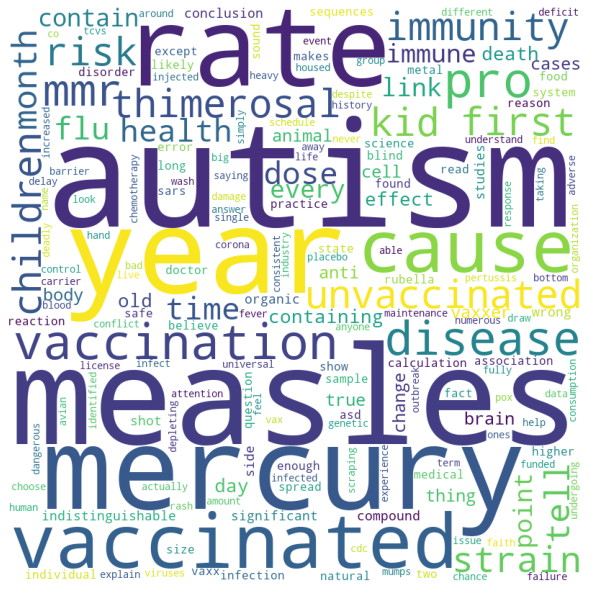

In [45]:
a = ['My name is', 'all you', 'your name', 'your name is what']
comment_words = ''
for val in tf_feature_names:
    #print(val)
    #tokens = val.split()
    comment_words += val + " "
#print(comment_words)  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                #stopwords = stop_words,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

# sentiment analysis

# MultinomialNB

In [46]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

# choose model base on cross validation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# evaluation metric: F-measure
from sklearn.metrics import classification_report

In [47]:
dfsent=pd.read_csv('sentiment_analysis_medical_drugs_redit.csv')

In [48]:
dfsent.dropna()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1
...,...,...,...,...
5274,5b5d129f3bab30fbb4740540a16856907657f005,"Hi Bee, Thanks for the update and the good new...",alimta,0
5275,1aa7dde5dc5249ebc3490c1fbac6ca6df48753a2,Have you had blood testing done to check your ...,entyvio,2
5276,e9159c3f836f453f5f133008d40b7e65f9e70a42,All the best to your husband and family.,opdivo,2
5277,63d57717bd0cf650f91a5137bd1b427ba922edea,"Hi bazza, luckily my eyes aren't so badly affe...",lucentis,2


In [49]:
text=dfsent['text'].tolist()
label=dfsent['sentiment'].tolist()

In [50]:
text[:3]

['Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.',
 'I can completely understand why you’d want to try it. But, results reported in lectures don’t always stand up to the scrutiny of peer-review during publication. There so much still to do before this is convincing. I hope that it does work out, I really do. And if you’re aware of and happy with the risks, then that’s great. I just think it’s important to present this in a balanced way, and to understand why we don’t move straight from the first show of promise in an animal study to using drugs on humans. There’s still a lot of animal data to gather, and human data to gather before an

In [51]:
label[:3]

[2, 2, 2]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.1, random_state=0)

In [53]:
print(len(X_train),len(y_train),len(X_test),len(y_test))

4751 4751 528 528


In [54]:
gram12_boo_count_vectorizer = CountVectorizer(encoding='latin-1', binary=True, ngram_range=(1,2), min_df=5)

In [55]:
# vectorize
X_train_vec = gram12_boo_count_vectorizer.fit_transform(X_train)
X_test_vec = gram12_boo_count_vectorizer.transform(X_test)

In [56]:
# initialize the MNB model
mnb_clf= MultinomialNB()

# use the training data to train the MNB model
mnb_clf.fit(X_train_vec,y_train)

MultinomialNB()

In [57]:
mnb_clf_pipe = Pipeline([('vect', CountVectorizer(encoding='latin-1', binary=True, ngram_range=(1,2), min_df=5)),
                        ('mnb', MultinomialNB())])
mnb_scores = cross_val_score(mnb_clf_pipe, X_train, y_train, cv=5)
mnb_avg = sum(mnb_scores)/len(mnb_scores)

In [58]:
mnb_avg

0.5394647185787813

In [59]:
# test model with test set, print out accuracy
mnb_clf.score(X_test_vec,y_test)

0.5132575757575758

In [60]:
y_pred_mnb = mnb_clf.fit(X_train_vec, y_train).predict(X_test_vec)

In [61]:
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred_mnb, target_names=target_names))

              precision    recall  f1-score   support

           0       0.33      0.19      0.24        75
           1       0.20      0.66      0.31        67
           2       0.80      0.55      0.65       386

    accuracy                           0.51       528
   macro avg       0.44      0.47      0.40       528
weighted avg       0.66      0.51      0.55       528



In [62]:
predtextvect= gram12_boo_count_vectorizer.transform(docs)

In [63]:
predlabels=mnb_clf.predict(predtextvect)

In [64]:
predlabels[:5]

array([2, 2, 2, 2, 2])

In [65]:
text_w_label= pd.DataFrame({"Prediction":predlabels, "Text":docs})

In [66]:
text_w_label.head()

,Prediction,Text
0,2,Your OP. It's not a myth. Only one vaccine con...
1,2,
2,2,Because Anti-Vaxxers have no sense
3,2,"What do you mean by ""your OP"". I am fairly new..."
4,2,"When they say there's no thimerasol, they mean..."


In [67]:
text_w_label.describe()

,Prediction
count,1110.000000
mean,1.647748
std,0.483515
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


In [68]:
# example text 2
text_w_label[text_w_label['Prediction']==2][:20]

,Prediction,Text
0,2,Your OP. It's not a myth. Only one vaccine con...
1,2,
2,2,Because Anti-Vaxxers have no sense
3,2,"What do you mean by ""your OP"". I am fairly new..."
4,2,"When they say there's no thimerasol, they mean..."
5,2,"The ""myth"" you're debunking is in regards to t..."
6,2,You'll have to read it again because I didn't ...
7,2,Nope. I didn't say anything about childhood va...
8,2,I didn't say thimerosal is mercury. I said thi...
9,2,Doctors recommend vaccines for whatever you're...


In [69]:
# example text 1
text_w_label[text_w_label['Prediction']==1][:20]

,Prediction,Text
10,1,I'm saying that even if you live away from peo...
11,1,Kind of hard to avoid exposure unless you aban...
12,1,Herd immunity to me is a delegation of one's r...
14,1,You finally admit there is mercury in vaccines...
15,1,Because it is an ethylmercury you monumental d...
17,1,You can be anything on the internet and you ch...
19,1,You just went full retard.
24,1,"What is thimerosal? I know it's a compound, bu..."
33,1,Please tell me what table salt is made of.
35,1,"I sure am, which is how I know there is mercur..."


In [70]:
# example text 0
text_w_label[text_w_label['Prediction']==0][:20]

,Prediction,Text
995,0,Sure. [Just published recently.]( Danish cohor...
999,0,Car insurance compensates for damages to your ...
1028,0,Oh. Another one yah!\nMoney is not a logical m...


# SVM

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

In [72]:
SVC_vectorizer = TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, ngram_range=(1,2))

In [73]:
# vectorize sentences
X_SVC_train_vect=SVC_vectorizer.fit_transform(X_train)
X_SVC_test_vect=SVC_vectorizer.transform(X_test)

# initialize the LinearSVC model
svm_clf = LinearSVC(C=1)
# fit estimator
svm_clf.fit(X_SVC_train_vect, y_train)
# accuracy
svm_clf.score(X_SVC_test_vect, y_test)

0.740530303030303

In [74]:
y_pred_svm = svm_clf.fit(X_train_vec, y_train).predict(X_test_vec)
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred_svm, target_names=target_names))

              precision    recall  f1-score   support

           0       0.47      0.31      0.37        75
           1       0.37      0.33      0.35        67
           2       0.79      0.85      0.82       386

    accuracy                           0.71       528
   macro avg       0.54      0.50      0.51       528
weighted avg       0.69      0.71      0.70       528



/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [75]:
svm_clf_pipe = Pipeline([('vect', TfidfVectorizer(encoding='latin-1', use_idf=True, min_df=5, ngram_range=(1,2))),
                        ('svm', LinearSVC(C=1))])
svm_scores = cross_val_score(svm_clf_pipe, X_train, y_train, cv=5)
svm_avg = sum(svm_scores)/len(svm_scores)

In [76]:
svm_avg

0.7274246499529581

In [77]:
SVC_text_vect=SVC_vectorizer.transform(docs)
y_SVC_pred=svm_clf.predict(SVC_text_vect)

In [78]:
text_w_label_svm= pd.DataFrame({"Prediction":y_SVC_pred, "Text":docs})

In [79]:
text_w_label_svm.head()

,Prediction,Text
0,2,Your OP. It's not a myth. Only one vaccine con...
1,2,
2,2,Because Anti-Vaxxers have no sense
3,2,"What do you mean by ""your OP"". I am fairly new..."
4,2,"When they say there's no thimerasol, they mean..."


In [80]:
text_w_label_svm.describe()

,Prediction
count,1110.0
mean,2.0
std,0.0
min,2.0
25%,2.0
50%,2.0
75%,2.0
max,2.0


In [81]:
# example text 2
text_w_label_svm[text_w_label_svm['Prediction']==2][:20]

,Prediction,Text
0,2,Your OP. It's not a myth. Only one vaccine con...
1,2,
2,2,Because Anti-Vaxxers have no sense
3,2,"What do you mean by ""your OP"". I am fairly new..."
4,2,"When they say there's no thimerasol, they mean..."
5,2,"The ""myth"" you're debunking is in regards to t..."
6,2,You'll have to read it again because I didn't ...
7,2,Nope. I didn't say anything about childhood va...
8,2,I didn't say thimerosal is mercury. I said thi...
9,2,Doctors recommend vaccines for whatever you're...


In [82]:
# example text 1
text_w_label_svm[text_w_label_svm['Prediction']==1][:20]

,Prediction,Text


In [83]:
# example text 0
text_w_label_svm[text_w_label_svm['Prediction']==0][:20]

,Prediction,Text


# textblob

In [84]:
TextBlob_label=[]
for d in docs:
    lab=TextBlob(d).sentiment.polarity
    TextBlob_label.append(lab)

In [85]:
TextBlob_label[:5]

[-0.125, 0.0, 0.0, -0.08806818181818182, -0.3125]

In [86]:
text_w_label_TB = pd.DataFrame({"Prediction":TextBlob_label, "Text":docs})

In [87]:
text_w_label_TB.head()

,Prediction,Text
0,-0.125000,Your OP. It's not a myth. Only one vaccine con...
1,0.000000,
2,0.000000,Because Anti-Vaxxers have no sense
3,-0.088068,"What do you mean by ""your OP"". I am fairly new..."
4,-0.312500,"When they say there's no thimerasol, they mean..."


In [88]:
text_w_label_TB.describe()

,Prediction
count,1110.000000
mean,0.053668
std,0.260980
min,-1.000000
25%,-0.005671
50%,0.000000
75%,0.175000
max,1.000000


In [89]:
# positive text
text_w_label_TB[text_w_label_TB['Prediction']>=0.1][:25]

,Prediction,Text
6,0.285714,You'll have to read it again because I didn't ...
8,0.425000,I didn't say thimerosal is mercury. I said thi...
9,0.318182,Doctors recommend vaccines for whatever you're...
10,0.159091,I'm saying that even if you live away from peo...
11,0.181667,Kind of hard to avoid exposure unless you aban...
16,0.133333,"Good thing I didn't say thimerosal is mercury,..."
26,0.300000,They're not lying! Your inability to grasp a s...
35,0.275000,"I sure am, which is how I know there is mercur..."
38,0.200000,"Yes, that can be a few vaccinations. I've been..."
40,0.800000,Lol


In [90]:
len(text_w_label_TB[text_w_label_TB['Prediction']>=0.1])

394

In [91]:
positivelist = text_w_label_TB[text_w_label_TB['Prediction']>=0.1][:25]

In [92]:
positivelist = positivelist['Text'].tolist()

In [93]:
positivelist

['You\'ll have to read it again because I didn\'t say that, the CDC did. You say one flu vaccine but the CDC says multiple. Check the CDC link. To paraphrase, "It\'s out of most single dose and in most multi-dose." That\'s more than one. I can\'t keep responding to people who won\'t even read what they\'re disagreeing with...',
 "I didn't say thimerosal is mercury. I said thimerosal contains mercury. You're not disagreeing with me. Again, I can't respond if you're not tracking the conversation. We won't get anywhere if you're not even willing to put your own shoes on...",
 "Doctors recommend vaccines for whatever you're most at risk for considering the area you live in. ",
 "I'm saying that even if you live away from people, you can still get diseases from plants / funghi. Things like Malaria, Dengue and JEV can be gotten from animals. \n\nAnd if you're on Reddit, you got some piece of technology. This is pretty silly. :P",
 "Kind of hard to avoid exposure unless you abandon being in c

In [94]:
# negative text
text_w_label_TB[text_w_label_TB['Prediction']<=-0.1][:25]

,Prediction,Text
0,-0.125000,Your OP. It's not a myth. Only one vaccine con...
4,-0.312500,"When they say there's no thimerasol, they mean..."
5,-0.400000,"The ""myth"" you're debunking is in regards to t..."
7,-0.214286,Nope. I didn't say anything about childhood va...
12,-0.250000,Herd immunity to me is a delegation of one's r...
19,-0.275000,You just went full retard.
20,-0.300000,"Not in my mind, but in the FDA's mind, ""Thimer..."
21,-0.300000,"Think about this. When you eat french fries, c..."
27,-0.191667,I never once said I was concerned about thimer...
36,-0.262500,I've been studying and debating vaccine safety...


In [95]:
len(text_w_label_TB[text_w_label_TB['Prediction']<=-0.1])

198

In [96]:
negativelist = text_w_label_TB[text_w_label_TB['Prediction']<=-0.1][:25]

In [97]:
negativelist = negativelist['Text'].tolist()

In [98]:
negativelist

["Your OP. It's not a myth. Only one vaccine contains it and you can get it without it. So your OP is pointless flex. ",
 "When they say there's no thimerasol, they mean in the childhood schedule. That IS a fact. ",
 'The "myth" you\'re debunking is in regards to the childhood schedule. ZERO OF THOSE VACCINES CONTAIN IT.  You\'re being a pedantic fuck for no reason. ',
 'Nope. I didn\'t say anything about childhood vaccines in my OP. The myth, as I stated plainly, is "Vaccines do not contain mercury." They do contain mercury. Not all, but some, so the statement is incorrect.',
 "Herd immunity to me is a delegation of one's responsibility of his wellbeing to others. That's basically what it is; regardless if a drug works or not. And that's insanity at its finest point having someone to blame others for his immune being grounded. It's unbelievable.",
 'You just went full retard.',
 'Not in my mind, but in the FDA\'s mind, "Thimerosal is a mercury-containing organic compound."\n\n\nBut yo

In [99]:
neutral = text_w_label_TB[text_w_label_TB['Prediction']>-0.1]

In [100]:
neutral = neutral[neutral['Prediction']<0.1]

In [101]:
neutral[:25]

,Prediction,Text
1,0.000000,
2,0.000000,Because Anti-Vaxxers have no sense
3,-0.088068,"What do you mean by ""your OP"". I am fairly new..."
13,-0.033333,I didn't admit there are. Two vaccines contain...
14,0.083333,You finally admit there is mercury in vaccines...
15,-0.088141,Because it is an ethylmercury you monumental d...
17,-0.079167,You can be anything on the internet and you ch...
18,0.000000,"Just ethylmercury, which is a form of this thi..."
22,0.000000,What's in table salt?
23,-0.083611,I agree with the statement because it's true. ...


In [102]:
len(neutral)

518

In [103]:
neutral = neutral['Text'].tolist()

In [104]:
neutral[:25]

['',
 'Because Anti-Vaxxers have no sense',
 'What do you mean by "your OP". I am fairly new to reddit.',
 "I didn't admit there are. Two vaccines contain thimerasol. That is a compound and not an element. If you'd like, I'll start a GoFundMe to put you into a basic chemistry class so you understand the fucking difference. Jesus Christ, it's literally been like arguing with an anti-vaxxer. You cannot retain anything taught to you, no matter how many people explain it to you.",
 "You finally admit there is mercury in vaccines. You arguing with yourself kid. I never said it's worrisome. I just said it's in there and that's a problem when doctors and TED talks are saying it's not. You seem to only be able to disagree with things I didn't say. 100% of my argument is that mercury is in vaccines, which you seem to suddenly agree with after spending an entire day saying the opposite. I'm gonna let go of your hand now. ✌️",
 'Because it is an ethylmercury you monumental dumbass. Also, just bec

In [ ]:
# positive:neutral:negative
# 394:518:198

# all above 3 categories are saved in a new csv file for handlableling

# hand labeled data

In [105]:
handlabel = pd.read_csv('IST736_project_manual_lable_75.csv')

In [106]:
handlabel.head()

,prediction,label,text
0,1,0,You\'ll have to read it again because I didn\'...
1,1,0,I didn't say thimerosal is mercury. I said thi...
2,1,1,Doctors recommend vaccines for whatever you're...
3,1,1,I'm saying that even if you live away from peo...
4,1,1,Kind of hard to avoid exposure unless you aban...


In [107]:
hand_test=handlabel['label'].tolist()
hand_pred=handlabel['prediction'].tolist()

In [108]:
target_names = ['1', '2', '0']
print(classification_report(hand_test, hand_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.68      0.39      0.49        44
           2       0.32      1.00      0.48         8
           0       0.56      0.61      0.58        23

    accuracy                           0.52        75
   macro avg       0.52      0.67      0.52        75
weighted avg       0.60      0.52      0.52        75

